# Imports

In [31]:
import os
import glob
import datetime
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
import spacy
# Define nlp class (includes tokenizer, lemmatization, POS tagging and NER)
nlp = spacy.load('es_core_news_sm')


# Constants and Definitions

In [14]:
# Path to all the articles
articles_path = '../data/articles'

# Path to images folder
images_path = '../images'


# Data Loading

In [28]:
# Keeps titles and content
titles = []
contents = []

# Iterates over all news txt files in bbc dataset
for filename in glob.iglob(f'{articles_path}/**',recursive=True):
    # Exclude directories and README
    if (not ("README" in filename)) and '.txt' in filename :
        # Opens file 
        with open(filename,'r', encoding='utf8') as file_n:
            # Readlines from file
            file_text = file_n.readlines()
            # Distinguish title from content
            title = filename.replace(f'{articles_path}/','')
            content = ' '.join(file_text[1:]).strip()
            # Keep content and title
            titles.append(title)
            contents.append(content)

# Creates dataframe of titles and content
data = pd.DataFrame({'filename':titles,'content':contents})

data.head(5)

,filename,content
0,0055--26-03-1996___B112__D86__A11___CALI___VAL...,"“Les brindaremos nuevas oportunidades”, dijo l..."
1,0101--13-04-1997___B118__D86___BOGOT___D.C.___...,Siete jóvenes menores de 20 años fueron asesin...
2,0165--17-11-1997___B118__D86_________EL_TIEMPO...,Niños combatientes\n • i\n e deben estremecer ...
3,0155--30-10-1997___D86__B118_________EL_NUEVO_...,• f\n no irán a combatir\n El presidente Ernes...
4,0040--09-12-1995___B114__D86_________EL_COLOMB...,"María Victoria Fallón\n ""Objetivo de Colombia:..."


# Preprocessing RAW text & filenames

In [37]:
# Gets attributes from filename
def get_attr_fname(fname):
    
    # Dictionary of attributes
    attr = {}
    
    # Defines splitters
    splitter = '__'
    splitter_date_id = '--'
    
    # Splits file into raw attributes
    raw_attr = fname.split(splitter)
    # Splits date and id
    id_date = raw_attr[0].split(splitter_date_id)
    
    # Gets attributes
    attr['id'] = int(id_date[0])
    attr['date'] = datetime.datetime.strptime(id_date[1], '%d-%m-%Y')
    attr['city'] = raw_attr[4].strip('_')
    attr['department'] = raw_attr[5].strip('_')
    attr['department'] = raw_attr[6].strip('_')
    
    
    return(attr, raw_attr)
print(data['filename'].loc[0])
print(get_attr_fname(data['filename'].loc[0]))

0055--26-03-1996___B112__D86__A11___CALI___VALLE_DEL_CAUCA___EL_PA_S___1B__________________-520232.txt
({'id': 55, 'date': datetime.datetime(1996, 3, 26, 0, 0)}, ['0055--26-03-1996', '_B112', 'D86', 'A11', '_CALI', '_VALLE_DEL_CAUCA', '_EL_PA_S', '_1B', '', '', '', '', '', '', '', '', '-520232.txt'])


# Train-Test Split

In [10]:
# Split train test
stop_ix = int(0.8*len(data.index))
data_train = data[:stop_ix]
data_test = data[stop_ix:]
len(data_train.index),len(data_test.index)

(160, 41)

# Simple Word Cloud 

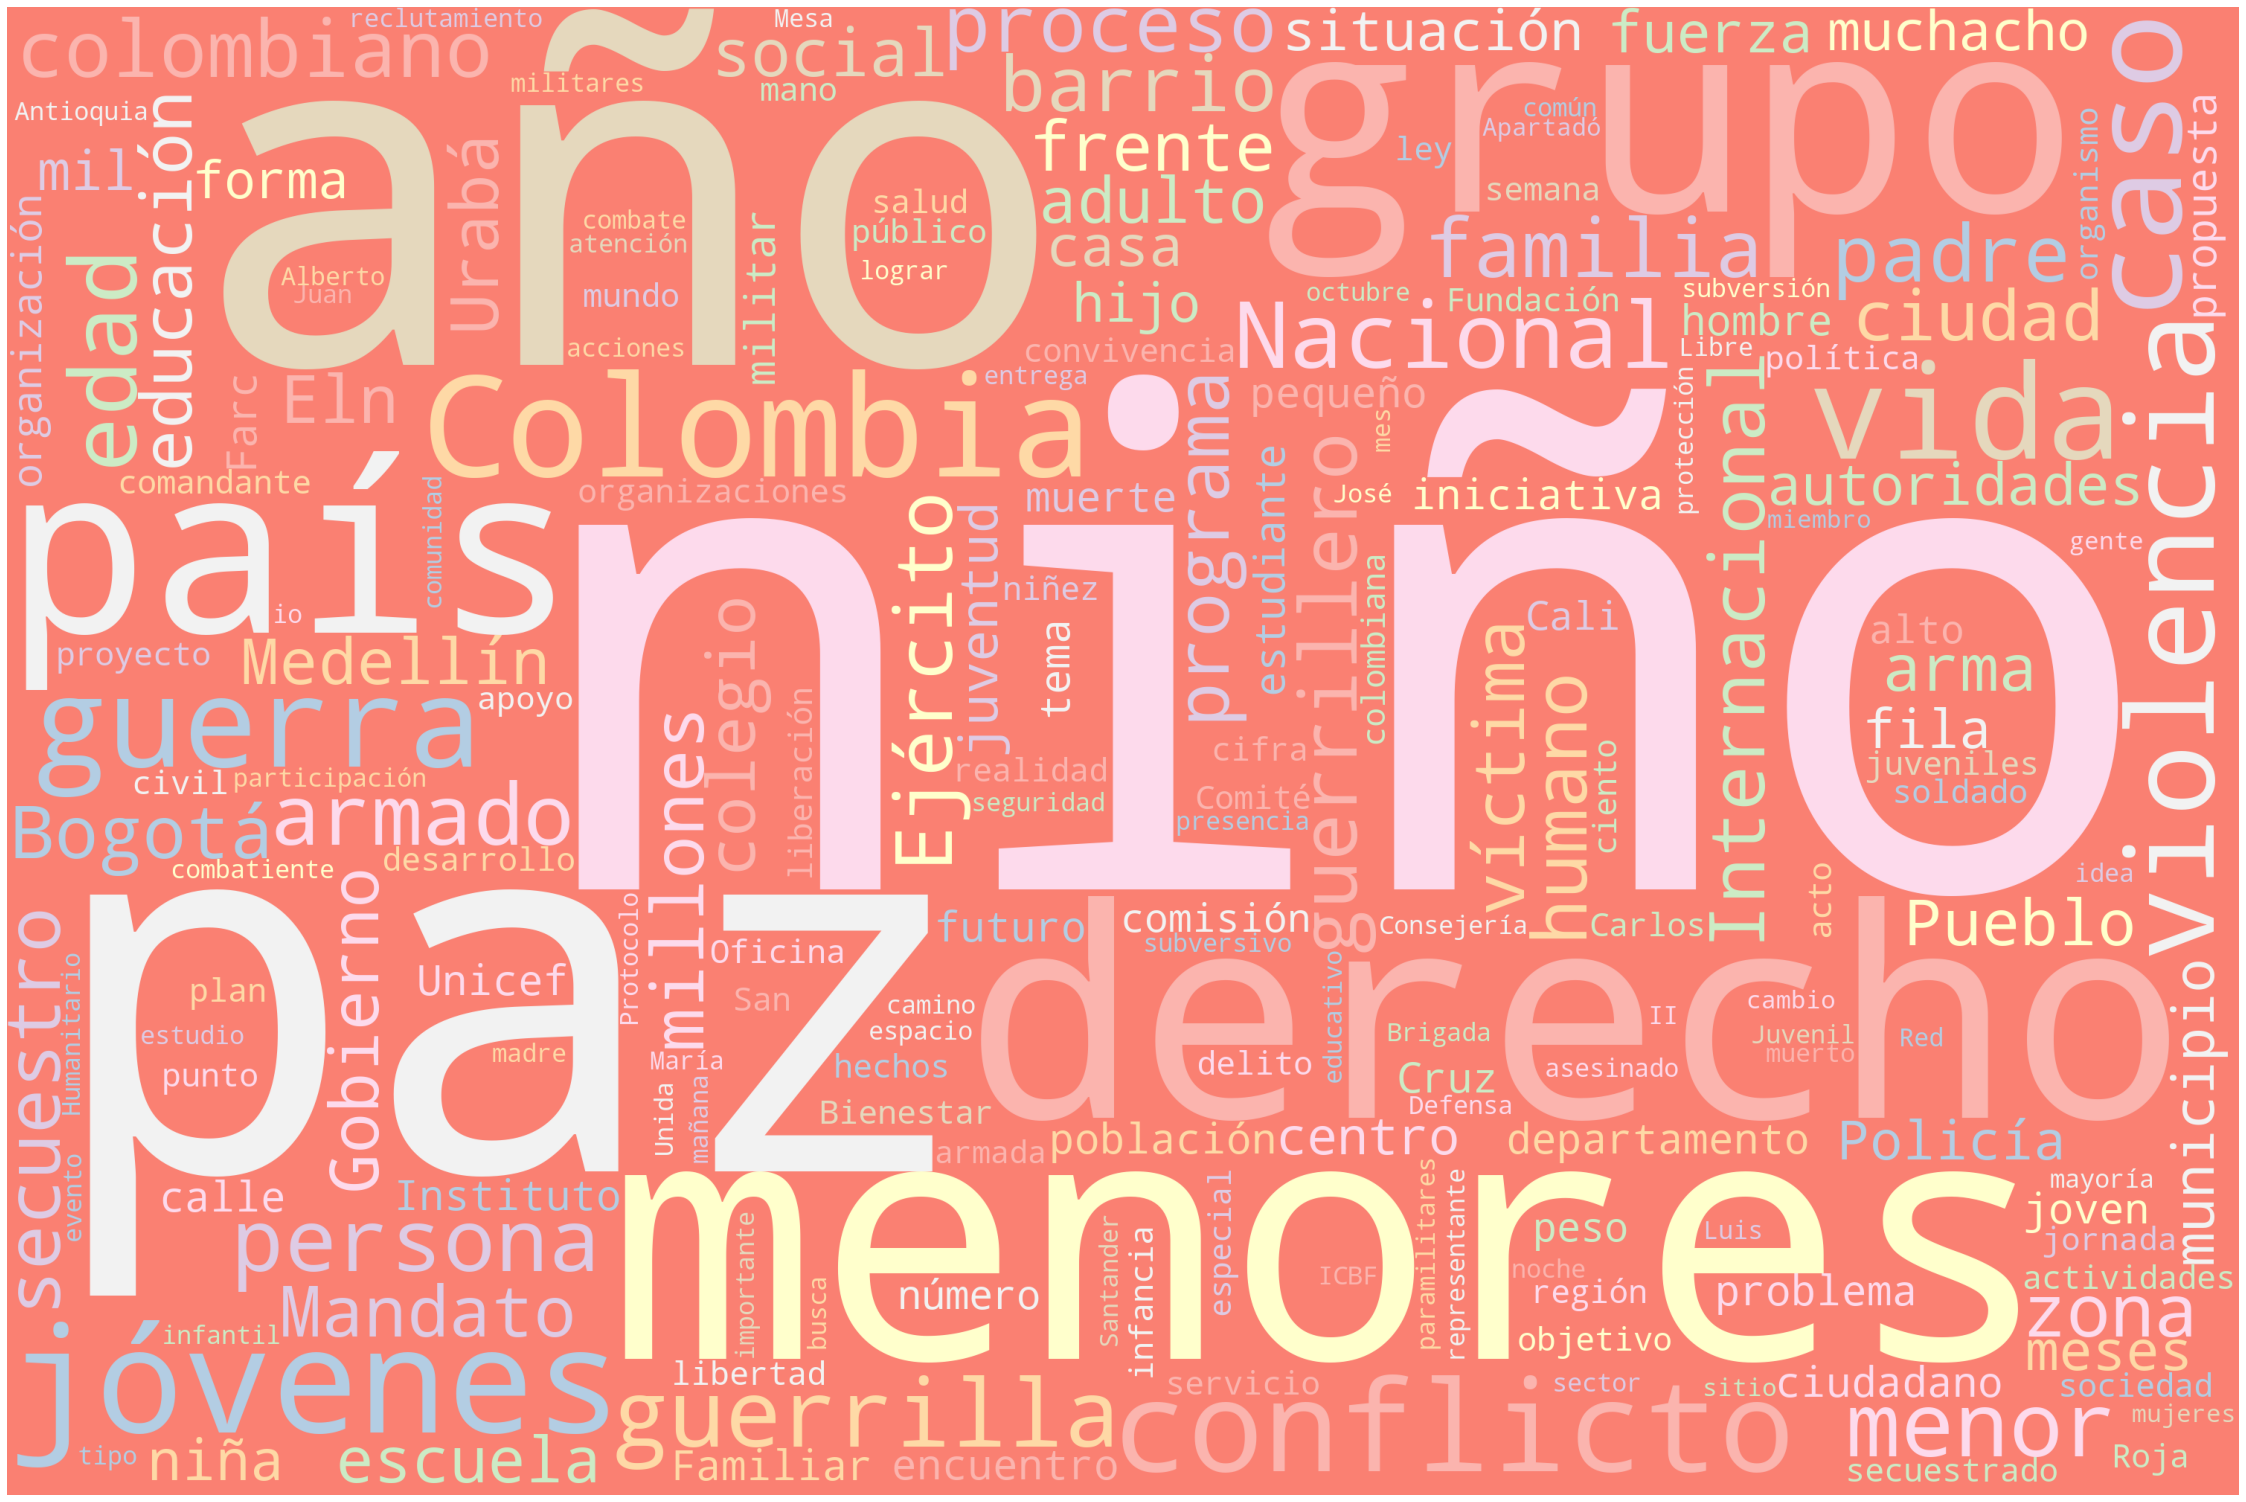

In [18]:
# Import package
from wordcloud import WordCloud

# Define a function to plot word cloud and savefile
def plot_cloud(wordcloud, file_to_save):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    
    # Saves file
    plt.savefig(f'{images_path}/wordcloud/{file_to_save}')
    

# Updates stopwords
stop_words = nlp.Defaults.stop_words.union(set({'y','a'}))
    
# Text of all articles together
overall_text = ' '.join(data['content'].array)

# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000,
                      random_state=1, background_color='salmon', colormap='Pastel1',
                      collocations=False, stopwords = nlp.Defaults.stop_words,
                      min_word_length=2).generate(overall_text)
# Plot
plot_cloud(wordcloud, 'overall_text.png')

# Preprocessing NLP

In [5]:
# Preprocess all data
data_train['preprocessed'] = data_train['content'].apply(lambda x: nlp(x))

data_train

<ipython-input-5-c4f5cb764d09>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['preprocessed'] = data_train['content'].apply(lambda x: nlp(x))


,title,content,preprocessed
0,"﻿26-03-1996 I B112, D86, A1 1 I CALI / VALLE D...","“Les brindaremos nuevas oportunidades”, dijo l...","(“, Les, brindaremos, nuevas, oportunidades, ”..."
1,﻿Pistoleros asesinaron a siete jóvenes en,Siete jóvenes menores de 20 años fueron asesin...,"(Siete, jóvenes, menores, de, 20, años, fueron..."
2,"﻿17-11-1997 IB118, D86I / I EL TIEMPO I 4A",Niños combatientes\n • i\n e deben estremecer ...,"(Niños, combatientes, \n , •, i, \n , e, deben..."
3,﻿Menores,• f\n no irán a combatir\n El presidente Ernes...,"(•, f, \n , no, irán, a, combatir, \n , El, pr..."
4,"﻿09-12-1995 I Bl I4,D86 I / I EL COLOMBIANO I 9C","María Victoria Fallón\n ""Objetivo de Colombia:...","(María, Victoria, Fallón, \n , "", Objetivo, de..."
...,...,...,...
155,﻿¿Quién quiere hoy? ¡Pues los,"""Que canten los niños que quieren la paz... po...","("", Que, canten, los, niños, que, quieren, la,..."
156,﻿Samper y la eventual devolución de los niños ...,‘Un paso hacia la ética de la guerra5\n .........,"(‘, Un, paso, hacia, la, ética, de, la, guerra..."
157,﻿Pregunta del día al gobierno local y la Fiscalía,¿Qué se sabe de la masacre de El Porvenir?\n H...,"(¿, Qué, se, sabe, de, la, masacre, de, El, Po..."
158,﻿Ei Encuentro de Lideres Juveniles trazó polít...,Los jóvenes de Urabá le apuestan a la vida\n F...,"(Los, jóvenes, de, Urabá, le, apuestan, a, la,..."


In [6]:
nlp.Defaults.stop_words

{'actualmente',
 'acuerdo',
 'adelante',
 'ademas',
 'además',
 'adrede',
 'afirmó',
 'agregó',
 'ahi',
 'ahora',
 'ahí',
 'al',
 'algo',
 'alguna',
 'algunas',
 'alguno',
 'algunos',
 'algún',
 'alli',
 'allí',
 'alrededor',
 'ambos',
 'ampleamos',
 'antano',
 'antaño',
 'ante',
 'anterior',
 'antes',
 'apenas',
 'aproximadamente',
 'aquel',
 'aquella',
 'aquellas',
 'aquello',
 'aquellos',
 'aqui',
 'aquél',
 'aquélla',
 'aquéllas',
 'aquéllos',
 'aquí',
 'arriba',
 'arribaabajo',
 'aseguró',
 'asi',
 'así',
 'atras',
 'aun',
 'aunque',
 'ayer',
 'añadió',
 'aún',
 'bajo',
 'bastante',
 'bien',
 'breve',
 'buen',
 'buena',
 'buenas',
 'bueno',
 'buenos',
 'cada',
 'casi',
 'cerca',
 'cierta',
 'ciertas',
 'cierto',
 'ciertos',
 'cinco',
 'claro',
 'comentó',
 'como',
 'con',
 'conmigo',
 'conocer',
 'conseguimos',
 'conseguir',
 'considera',
 'consideró',
 'consigo',
 'consigue',
 'consiguen',
 'consigues',
 'contigo',
 'contra',
 'cosas',
 'creo',
 'cual',
 'cuales',
 'cualquier',
 